In [2]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/NLP/project

Mounted at /gdrive
/gdrive/My Drive/NLP/project


In [3]:
%pip install transformers

     |████████████████████████████████| 2.9 MB 9.1 MB/s 
     |████████████████████████████████| 3.3 MB 61.9 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
     |████████████████████████████████| 895 kB 57.8 MB/s 
     |████████████████████████████████| 56 kB 6.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!nvidia-smi

Tue Oct 19 13:21:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

from gpt2 import TweetDataset, train, generate, save_model, load_model
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, __version__ 

import nltk
nltk.download('punkt')
torch.cuda.empty_cache()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
device = torch.device('cuda')
BOS_TOKEN = "<BOS>"
EOS_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token=BOS_TOKEN, eos_token=EOS_TOKEN, pad_token=PAD_TOKEN)

10/19/2021 13:22:11 - DEBUG - Attempting to acquire lock 140396235706064 on /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock
10/19/2021 13:22:11 - DEBUG - Lock 140396235706064 acquired on /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

10/19/2021 13:22:12 - DEBUG - Attempting to release lock 140396235706064 on /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock
10/19/2021 13:22:12 - DEBUG - Lock 140396235706064 released on /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock
10/19/2021 13:22:12 - DEBUG - Attempting to acquire lock 140396235706064 on /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
10/19/2021 13:22:12 - DEBUG - Lock 140396235706064 acquired on /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

10/19/2021 13:22:13 - DEBUG - Attempting to release lock 140396235706064 on /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
10/19/2021 13:22:13 - DEBUG - Lock 140396235706064 released on /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
10/19/2021 13:22:14 - DEBUG - Attempting to acquire lock 140396235706320 on /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0.lock
10/19/2021 13:22:14 - DEBUG - Lock 140396235706320 acquired on /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0.lock


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

10/19/2021 13:22:14 - DEBUG - Attempting to release lock 140396235706320 on /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0.lock
10/19/2021 13:22:14 - DEBUG - Lock 140396235706320 released on /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0.lock
10/19/2021 13:22:15 - DEBUG - Attempting to acquire lock 140396235593680 on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
10/19/2021 13:22:15 - DEBUG - Lock 140396235593680 acquired on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

10/19/2021 13:22:15 - DEBUG - Attempting to release lock 140396235593680 on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
10/19/2021 13:22:15 - DEBUG - Lock 140396235593680 released on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Training

In [6]:
epochs = 5
learning_rate = 5e-4
epsilon = 1e-8
sample_every = 100
batch_size = 2
configuration = GPT2Config.from_pretrained("gpt2")

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

# this step is necessary because I've added some tokens to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [7]:
def train_loss_plot(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')

    # Plot the loss
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])
    plt.show()

## Elon Musk

In [8]:
train_dataset = TweetDataset(tokenizer, 'data/elonmusk/train.txt')
val_dataset = TweetDataset(tokenizer, 'data/elonmusk/test.txt')

10/19/2021 01:18:25 - INFO - Creating features from dataset file at data/elonmusk/train.txt
10/19/2021 01:18:26 - INFO - Creating features from dataset file at data/elonmusk/test.txt


In [9]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset), # Select batches randomly
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size=batch_size
)

In [10]:
# Fine-tune the model on the training dataset and run validation on the test dataset
training_stats = train(model, device, optimizer, train_dataloader, val_dataloader, tokenizer,
                       epochs=epochs, sample_every=sample_every)

10/19/2021 01:18:27 - INFO - ======== Epoch 1 / 5 ========
10/19/2021 01:18:27 - INFO - Training...
10/19/2021 01:18:55 - INFO - Batch   100  of  1,034. Loss: 0.21095162630081177.   Elapsed: 0:00:28.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 01:18:55 - INFO - Sample 0:  The is of a the, 
10/19/2021 01:19:24 - INFO - Batch   200  of  1,034. Loss: 0.2537640929222107.   Elapsed: 0:00:57.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 01:19:24 - INFO - Sample 0:  We can-com are you had to take, be 
10/19/2021 01:19:52 - INFO - Batch   300  of  1,034. Loss: 0.25468331575393677.   Elapsed: 0:01:25.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 01:19:52 - INFO - Sample 0:  The last night out with a couple of the next year (1.2 month in 2016!
10/19/2021 01:20:21 - INFO - Batch   400  of  1,034. Loss: 0.18789243698120117.   Elapsed: 0:01:54.
Setting `pad_token_id` to `eos_token_id`:

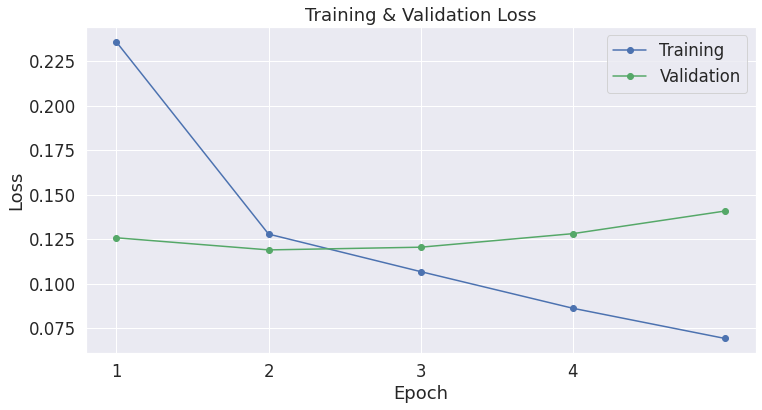

In [11]:
# Display the loss plot from training
train_loss_plot(training_stats)


In [12]:
# Save the model
save_model('elonmusk', model, tokenizer)

10/19/2021 01:44:05 - INFO - Saving model to models/elonmusk
10/19/2021 01:44:07 - INFO - Done saving. Model is located at models/elonmusk.


## Andrej Karpathy

In [13]:
train_dataset = TweetDataset(tokenizer, 'data/karpathy/train.txt')
val_dataset = TweetDataset(tokenizer, 'data/karpathy/test.txt')

10/19/2021 01:44:08 - INFO - Creating features from dataset file at data/karpathy/train.txt
10/19/2021 01:44:10 - INFO - Creating features from dataset file at data/karpathy/test.txt


In [14]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset), # Select batches randomly
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size=batch_size
)

In [15]:
# Fine-tune the model on the training dataset and run validation on the test dataset
training_stats = train(model, device, optimizer, train_dataloader, val_dataloader, tokenizer,
                       epochs=epochs, sample_every=sample_every)

10/19/2021 01:44:11 - INFO - ======== Epoch 1 / 5 ========
10/19/2021 01:44:11 - INFO - Training...
10/19/2021 01:44:40 - INFO - Batch   100  of  1,337. Loss: 0.27770471572875977.   Elapsed: 0:00:28.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 01:44:40 - INFO - Sample 0:  I'm not expecting a very good game of GPG. So, it is definitely what you
10/19/2021 01:45:08 - INFO - Batch   200  of  1,337. Loss: 0.4353541135787964.   Elapsed: 0:00:57.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 01:45:08 - INFO - Sample 0:  I'm learning about the big picture of what people want.  (yes, it's really
10/19/2021 01:45:37 - INFO - Batch   300  of  1,337. Loss: 0.1451556533575058.   Elapsed: 0:01:25.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 01:45:37 - INFO - Sample 0:  New blog article on how the latest AI system is designed. What will we do? 
10/19/2021 01:46:05 - INFO - Batch   400  

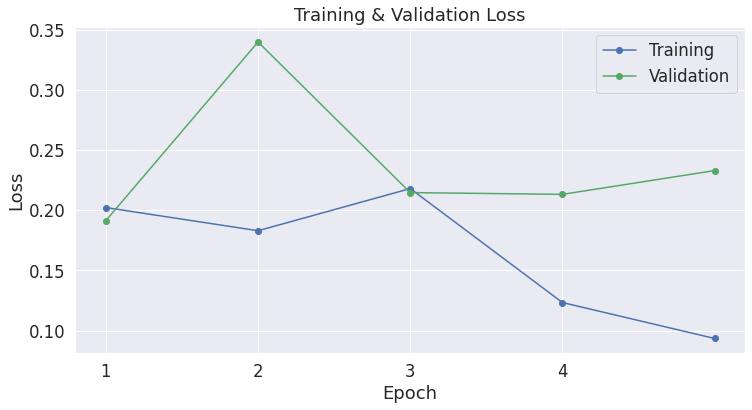

In [16]:
# Display the loss plot from training
train_loss_plot(training_stats)

In [17]:
# Save the model
save_model('karpathy', model, tokenizer)

10/19/2021 02:17:21 - INFO - Saving model to models/karpathy
10/19/2021 02:17:24 - INFO - Done saving. Model is located at models/karpathy.


## Barack Obama

In [ ]:
epochs = 3

In [18]:
train_dataset = TweetDataset(tokenizer, 'data/BarackObama/train.txt')
val_dataset = TweetDataset(tokenizer, 'data/BarackObama/test.txt')

10/19/2021 02:17:26 - INFO - Creating features from dataset file at data/BarackObama/train.txt
10/19/2021 02:17:31 - INFO - Creating features from dataset file at data/BarackObama/test.txt


In [19]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset), # Select batches randomly
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size=batch_size
)

In [20]:
# Fine-tune the model on the training dataset and run validation on the test dataset
training_stats = train(model, device, optimizer, train_dataloader, val_dataloader, tokenizer,
                       epochs=epochs, sample_every=sample_every)

10/19/2021 02:17:32 - INFO - ======== Epoch 1 / 5 ========
10/19/2021 02:17:32 - INFO - Training...
10/19/2021 02:18:01 - INFO - Batch   100  of  4,708. Loss: 0.11321065574884415.   Elapsed: 0:00:28.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 02:18:01 - INFO - Sample 0:  "We have a strong incentive, the right to take from more important national policy." —President
10/19/2021 02:18:29 - INFO - Batch   200  of  4,708. Loss: 0.2953515946865082.   Elapsed: 0:00:57.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 02:18:29 - INFO - Sample 0:  If you’re getting ready, President Obama told his grandmother that he wishes to be a
10/19/2021 02:18:57 - INFO - Batch   300  of  4,708. Loss: 0.09818953275680542.   Elapsed: 0:01:25.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 02:18:58 - INFO - Sample 0:  President Obama: "I've been doing much better than ever, but I have made it in
10/19

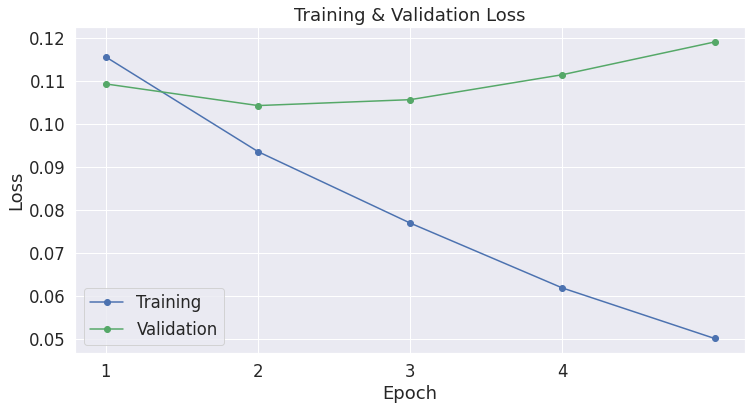

In [21]:
# Display the loss plot from training
train_loss_plot(training_stats)

In [22]:
# Save the model
save_model('BarackObama', model, tokenizer)

10/19/2021 04:14:21 - INFO - Saving model to models/BarackObama
10/19/2021 04:14:23 - INFO - Done saving. Model is located at models/BarackObama.


# Generation

## Elon Musk

In [12]:
model, tokenizer = load_model('elonmusk')
model = model.to(device)

10/19/2021 13:24:59 - INFO - Loading model from models...
10/19/2021 13:25:01 - INFO - Loaded fine-tuned GPT-2 model
10/19/2021 13:25:01 - INFO - The GPT-2 model has 148 different named parameters.
10/19/2021 13:25:01 - INFO - ==== Embedding Layer ====
10/19/2021 13:25:01 - INFO - transformer.wte.weight                                  (50260, 768)
10/19/2021 13:25:01 - INFO - transformer.wpe.weight                                   (1024, 768)
10/19/2021 13:25:01 - INFO - ==== First Transformer ====
10/19/2021 13:25:01 - INFO - transformer.h.0.ln_1.weight                                   (768,)
10/19/2021 13:25:01 - INFO - transformer.h.0.ln_1.bias                                     (768,)
10/19/2021 13:25:01 - INFO - transformer.h.0.attn.c_attn.weight                       (768, 2304)
10/19/2021 13:25:01 - INFO - transformer.h.0.attn.c_attn.bias                             (2304,)
10/19/2021 13:25:01 - INFO - transformer.h.0.attn.c_proj.weight                        (768, 768)
10/1

In [15]:
tweets = generate(model, device, tokenizer, n_sequences=10, max_length=50)
tweets

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 13:26:24 - INFO - Sample 0:  Will do a talk on energy and transport at Oxford Univ oxfordmartin.uk Earth Temperature Timeline 
10/19/2021 13:26:24 - INFO - Sample 1:  Tesla Solar Tile roof tiles can be ordered for 240k as well. More in days to follow, but there is no need of solar power outages from the oven 
10/19/2021 13:26:24 - INFO - Sample 2:  If you want a Tesla built in your garage, please do so before noon on Monday. 
10/19/2021 13:26:24 - INFO - Sample 3:  Great work by Tesla owners & cyclists in South Australia. They are now owning a Model X for the first time! 
10/19/2021 13:26:24 - INFO - Sample 4:  My new toaster 
10/19/2021 13:26:24 - INFO - Sample 5:  Launch at our Cape Canaveral tracking cameras! 
10/19/2021 13:26:24 - INFO - Sample 6:  Boring Company will get back to Autopilot update blog shortly. That's important because there’s an over-arching tendency toward a near permanent decline i

[' Will do a talk on energy and transport at Oxford Univ oxfordmartin.uk Earth Temperature Timeline ',
 ' Tesla Solar Tile roof tiles can be ordered for 240k as well. More in days to follow, but there is no need of solar power outages from the oven ',
 ' If you want a Tesla built in your garage, please do so before noon on Monday. ',
 ' Great work by Tesla owners & cyclists in South Australia. They are now owning a Model X for the first time! ',
 ' My new toaster ',
 ' Launch at our Cape Canaveral tracking cameras! ',
 " Boring Company will get back to Autopilot update blog shortly. That's important because there’s an over-arching tendency toward a near permanent decline in use of electric vehicles & battery cells for residential users ",
 ' Tesla Model S is now faster than expected, but there are some areas of uncertainty in the graph that matter. This post will be a long one... ',
 ' Model X rated as most efficient car ever ',
 " Rocket reentry is good now that we've completely seale

## Andrej Karpathy

In [17]:
model, tokenizer = load_model('karpathy')
model = model.to(device)

10/19/2021 13:27:24 - INFO - Loading model from models...
10/19/2021 13:27:32 - INFO - Loaded fine-tuned GPT-2 model
10/19/2021 13:27:32 - INFO - The GPT-2 model has 148 different named parameters.
10/19/2021 13:27:32 - INFO - ==== Embedding Layer ====
10/19/2021 13:27:32 - INFO - transformer.wte.weight                                  (50260, 768)
10/19/2021 13:27:32 - INFO - transformer.wpe.weight                                   (1024, 768)
10/19/2021 13:27:32 - INFO - ==== First Transformer ====
10/19/2021 13:27:32 - INFO - transformer.h.0.ln_1.weight                                   (768,)
10/19/2021 13:27:32 - INFO - transformer.h.0.ln_1.bias                                     (768,)
10/19/2021 13:27:32 - INFO - transformer.h.0.attn.c_attn.weight                       (768, 2304)
10/19/2021 13:27:32 - INFO - transformer.h.0.attn.c_attn.bias                             (2304,)
10/19/2021 13:27:32 - INFO - transformer.h.0.attn.c_proj.weight                        (768, 768)
10/1

In [19]:
tweets = generate(model, device, tokenizer, n_sequences=10, max_length=50)
tweets

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 13:28:36 - INFO - Sample 0:  The new Google Glass winners are up to 400:  (I'm not quite happy about this.) 1) It's nice! 2). I also don't want one, get the latest results from these sources. Also news on them is getting
10/19/2021 13:28:36 - INFO - Sample 1:  You can't work on an Academic Search without it. And that's because you have to, right? 
10/19/2021 13:28:36 - INFO - Sample 2:  Aww my boss is still building a robot with us all robots that people came out today. 
10/19/2021 13:28:36 - INFO - Sample 3:  The number of people leaving the bay area is growing linearly and roughly  3-15, but at 13. In mean this’s just a lot for these numbers... #thelittlethings  
10/19/2021 13:28:36 - INFO - Sample 4:  Nice article on the latest papers from Big Data  I have a list of 10 "Tabs" in arXiv right now: e.g., my CVPR, CIFAR-10 and some News junk pages! Thanks GPT
10/19/2021 13:28:36 - INFO - Sample 5:  I'm tr

[" The new Google Glass winners are up to 400:  (I'm not quite happy about this.) 1) It's nice! 2). I also don't want one, get the latest results from these sources. Also news on them is getting",
 " You can't work on an Academic Search without it. And that's because you have to, right? ",
 ' Aww my boss is still building a robot with us all robots that people came out today. ',
 ' The number of people leaving the bay area is growing linearly and roughly  3-15, but at 13. In mean this’s just a lot for these numbers... #thelittlethings \xa0',
 ' Nice article on the latest papers from Big Data  I have a list of 10 "Tabs" in arXiv right now: e.g., my CVPR, CIFAR-10 and some News junk pages! Thanks GPT',
 " I'm trying to use my Oculus VR headset on Vive. Is this a big deal? ",
 " This was a fun hack I put on top of ConvNetJS. And now, that's pretty much the code to use for this right :) ",
 " My Python scripts are about 40 lines and 10 line segments. It's like I just ran the longest benchm

## Barack Obama

In [20]:
model, tokenizer = load_model('BarackObama')
model = model.to(device)

10/19/2021 13:28:43 - INFO - Loading model from models...
10/19/2021 13:28:50 - INFO - Loaded fine-tuned GPT-2 model
10/19/2021 13:28:50 - INFO - The GPT-2 model has 148 different named parameters.
10/19/2021 13:28:50 - INFO - ==== Embedding Layer ====
10/19/2021 13:28:50 - INFO - transformer.wte.weight                                  (50260, 768)
10/19/2021 13:28:50 - INFO - transformer.wpe.weight                                   (1024, 768)
10/19/2021 13:28:50 - INFO - ==== First Transformer ====
10/19/2021 13:28:50 - INFO - transformer.h.0.ln_1.weight                                   (768,)
10/19/2021 13:28:50 - INFO - transformer.h.0.ln_1.bias                                     (768,)
10/19/2021 13:28:50 - INFO - transformer.h.0.attn.c_attn.weight                       (768, 2304)
10/19/2021 13:28:50 - INFO - transformer.h.0.attn.c_attn.bias                             (2304,)
10/19/2021 13:28:50 - INFO - transformer.h.0.attn.c_proj.weight                        (768, 768)
10/1

In [21]:
tweets = generate(model, device, tokenizer, n_sequences=10, max_length=50)
tweets

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10/19/2021 13:28:51 - INFO - Sample 0:  President Obama: "I’m not going to walk away from the promise of clean energy." #StrongerWithObama 
10/19/2021 13:28:51 - INFO - Sample 1:  The U.S.' economy is booming—and it's creating jobs right now by the fastest rate in 40 years:  #ActOnJobs 
10/19/2021 13:28:51 - INFO - Sample 2:  President Obama: “Our first priority is making it easier for companies to sell products overseas so they’re also known no American home. That means I keep investing in the world!” 
10/19/2021 13:28:51 - INFO - Sample 3:  "Let's put some folks back to work and do our job." —President Obama #OpportunityForAll 
10/19/2021 13:28:51 - INFO - Sample 4:  The President just spoke about the economy at a Town Hall in Cincinnati, Ohio. Watch live: 
10/19/2021 13:28:51 - INFO - Sample 5:  Obama: "On the battlefield of justice, men and women in uniform have fought for something greater than themselves." #F

[' President Obama: "I’m not going to walk away from the promise of clean energy." #StrongerWithObama ',
 " The U.S.' economy is booming—and it's creating jobs right now by the fastest rate in 40 years:  #ActOnJobs ",
 ' President Obama: “Our first priority is making it easier for companies to sell products overseas so they’re also known no American home. That means I keep investing in the world!” ',
 ' "Let\'s put some folks back to work and do our job." —President Obama #OpportunityForAll ',
 ' The President just spoke about the economy at a Town Hall in Cincinnati, Ohio. Watch live: ',
 ' Obama: "On the battlefield of justice, men and women in uniform have fought for something greater than themselves." #Forward ',
 ' Today is a great day to celebrate the 50th anniversary of Americans with Disabilities Act––a lifeline for millions. ',
 ' "As Americans, we should be proud of what this achievement." —President Obama #IranDeal ',
 ' President Obama: "You won\'t go broke just because you

# Analysis

TODO: write analysis